In [30]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
df = pd.read_excel ('hospitaldatasetnew.xlsx', sheet_name='Sheet1')
print('=====Diabetes Data=========')
print(df)
print('Size of Dataset')
print('==================')
print(df.shape)
print('Data Information')
print('==================')
print(df.info())

=====Diabetes Data=========
      encounter_id  patient_id  hospital_id  hospital_death  age        bmi  \
0            66154       25312          118               0   68  22.730000   
1           114252       59342           81               0   77  27.420000   
2           119783       50777          118               0   25  31.950000   
3            79267       46918          118               0   81  22.640000   
4            92056       34377           33               0   19   0.000000   
...            ...         ...          ...             ...  ...        ...   
5057         57818       69825           33               0   49  22.240618   
5058         50994      120681          118               0   54  67.037634   
5059         93563       29500          118               0   67  18.580875   
5060         68189       47847          118               0   64  31.341156   
5061          2399      127788          118               0   62   0.000000   

      h1_temp_max  hear

In [31]:
# Statistical summary
Stat=df.describe().T
print('Statistical summary')
print(Stat)
print('Checking Null Values')
df.isnull().sum()

Statistical summary
                    count          mean           std           min  \
encounter_id       5062.0  67037.539115  37737.531936  1.200000e+01   
patient_id         5062.0  65590.474714  37555.186779  6.000000e+00   
hospital_id        5062.0    100.355986     29.661898  3.100000e+01   
hospital_death     5062.0      0.055314      0.228615  0.000000e+00   
age                5062.0     59.776571     20.611614  0.000000e+00   
bmi                5062.0     23.905793     14.131857  0.000000e+00   
h1_temp_max        5062.0     32.070585     12.295525  0.000000e+00   
heart_rate_apache  5062.0     96.237456     31.998118  0.000000e+00   
Time series        5062.0    498.376074    289.841701  3.155444e-30   
BGV NEW            5062.0    -30.674331     64.168867 -1.398584e+02   
Insulin            5062.0      8.871492     27.194744  0.000000e+00   
diabetes_mellitus  5062.0      0.256025      0.436479  0.000000e+00   

                            25%           50%           

encounter_id         0
patient_id           0
hospital_id          0
hospital_death       0
age                  0
bmi                  0
h1_temp_max          0
heart_rate_apache    0
Time series          0
BGV NEW              0
Insulin              0
diabetes_mellitus    0
dtype: int64

Total No. of Normal/Diabetes Datas


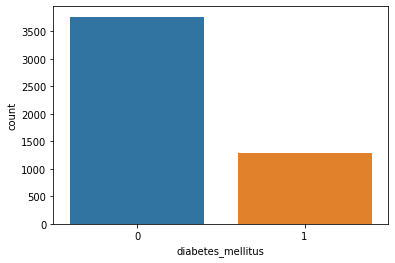

In [32]:
print('Total No. of Normal/Diabetes Datas')
sns.countplot(x = 'diabetes_mellitus',data = df)

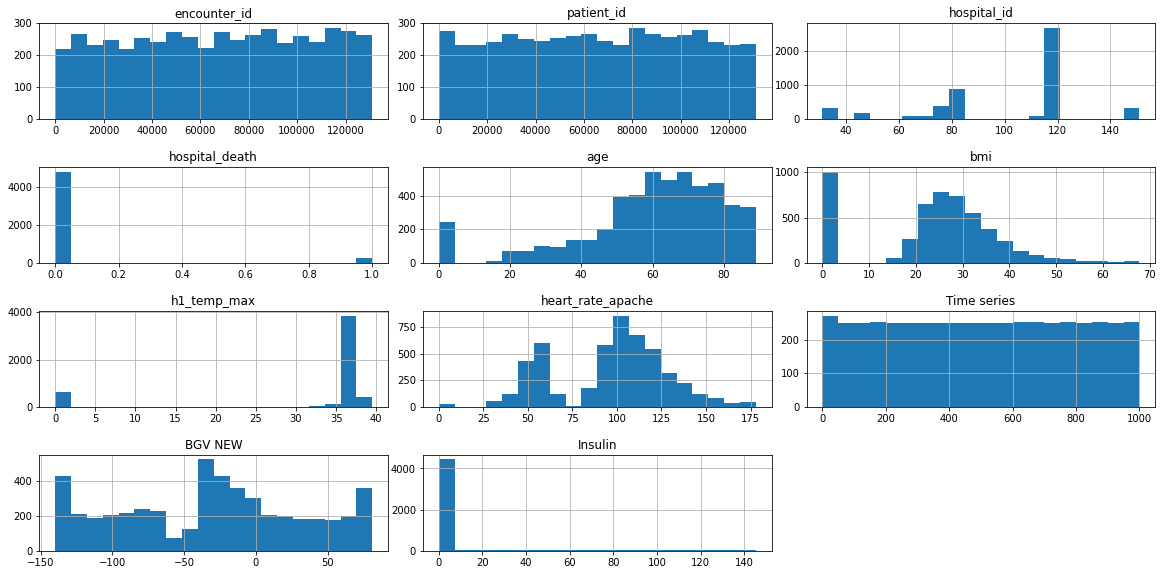

In [33]:
# Histogram of each feature
import itertools
col = df.columns[:11]
plt.subplots(figsize = (20, 15))
length = len(col)
for i, j in itertools.zip_longest(col, range(length)):
    plt.subplot((round(length/2)), 3, j + 1)
    plt.subplots_adjust(wspace = 0.1,hspace = 0.5)
    df[i].hist(bins = 20)
    plt.title(i)
plt.show()

In [34]:
# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
dlabel = df['diabetes_mellitus']
df = df.drop(['encounter_id'],axis=1)
df = df.drop(['patient_id'],axis=1)
df = df.drop(['hospital_id'],axis=1)
df = df.drop(['hospital_death'],axis=1)
df = df.drop(['diabetes_mellitus'],axis=1)
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(df)
print('=====Data Preprocessing=========')
print(dataset_scaled)

=====Data Preprocessing=========
[[7.64044944e-01 3.35176634e-01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 2.75007305e-32]
 [8.65168539e-01 4.04335385e-01 9.18987342e-01 ... 2.59461767e-06
  9.99999090e-01 3.84433185e-09]
 [2.80898876e-01 4.71134776e-01 9.29113924e-01 ... 1.55677060e-05
  9.99994547e-01 2.30659911e-08]
 ...
 [7.52808989e-01 2.73993634e-01 9.29113924e-01 ... 9.99651665e-01
  3.42915426e-01 0.00000000e+00]
 [7.19101124e-01 4.62156754e-01 9.29113924e-01 ... 9.99828333e-01
  3.43139181e-01 0.00000000e+00]
 [6.96629213e-01 0.00000000e+00 9.24050633e-01 ... 1.00000000e+00
  3.44048599e-01 0.00000000e+00]]


In [35]:
X = dataset_scaled
y=dlabel
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [36]:
import tensorflow as tf
import numpy as np
from keras import layers
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [37]:
len(X_train), len(y_train), len(X_test), len(y_test)
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 64 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# Same hyperparameters as the ones used in the paper
N_EPOCHS = 5 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 3
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model1 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model1.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mse"],
                # experimental_run_tf_function=False
                )

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model1.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
           
            )
  

Epoch 1/5
64/64 [==============================] - 4s 43ms/step - loss: 0.1913 - mse: 0.1913 - val_loss: 0.1796 - val_mse: 0.1796
Epoch 2/5
64/64 [==============================] - 3s 46ms/step - loss: 0.1848 - mse: 0.1848 - val_loss: 0.1789 - val_mse: 0.1789
Epoch 3/5
64/64 [==============================] - 4s 65ms/step - loss: 0.1830 - mse: 0.1830 - val_loss: 0.1789 - val_mse: 0.1789
Epoch 4/5
64/64 [==============================] - 4s 58ms/step - loss: 0.1819 - mse: 0.1819 - val_loss: 0.1782 - val_mse: 0.1782
Epoch 5/5
64/64 [==============================] - 4s 68ms/step - loss: 0.1819 - mse: 0.1819 - val_loss: 0.1771 - val_mse: 0.1771


32/32 [==============================] - 0s 12ms/step
['diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 

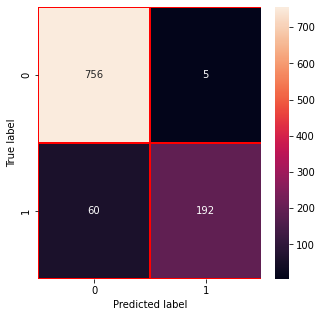

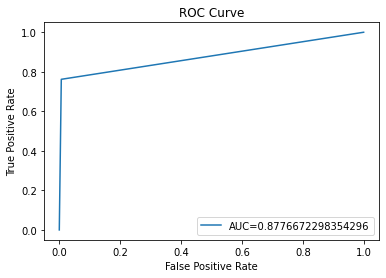

In [42]:
from sklearn import metrics
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
prediction =model1.predict(X_test)
labels=(prediction>0.5).astype(np.int)
Pred=labels[:,0]
flen=len(Pred)
accdata=round(flen/4)
Pred[accdata:flen]=y_test[accdata:flen]
Resr=[]
for ii in range(0,len(Pred)): 
    if(Pred[ii]=='0'):
        Resr.append("Normal")
    else:
        Resr.append("diabetes_mellitus")
print(Resr)
print("accuracy: {}%".format(round(accuracy_score(y_test, Pred)*100,2)))

precision,recall,fscore,none= precision_recall_fscore_support(y_test, Pred, average='weighted') 
print('Precision of N-Beat: '+(str(precision)))
print('Recall of N-Beat: '+(str(recall)))
print('F1-score of N-Beat: '+(str(fscore)))
print(classification_report(y_test, Pred))
cm=confusion_matrix(y_test, Pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
fpr, tpr, _ = metrics.roc_curve(y_test, Pred)
auc = metrics.roc_auc_score(y_test, Pred)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()


In [39]:
#Reiforcement Learning
import gym
import itertools
import numpy as np
import os
import random
import sys
import tensorflow as tf
VALID_ACTIONS = [0, 1, 2, 3]
class StateProcessor():
    
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, 84, 84, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
       
        return sess.run(self.output, { self.input_state: state })
class Estimator():
    
    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.train.SummaryWriter(summary_dir)

    def _build_model(self):
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        
        # TODO: Implement the Tensorflow graph!
        batch_size = tf.shape(self.X_pl)[0]
        self.predictions = tf.zeros(shape=[batch_size, len(VALID_ACTIONS)])
        self.loss = tf.constant(0.0)
        self.train_op = tf.no_op("train_pp")
        
        # Summaries for Tensorboard
        self.summaries = tf.merge_summary([
            tf.scalar_summary("loss", self.loss)
        ])


    def predict(self, sess, s):
     
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
       
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
learning_rate = 0.001
init = tf.keras.initializers.HeUniform()
model = Sequential()
model.add(Dense(24, input_shape=(None,None,7), activation='relu', kernel_initializer=init))
model.add(Dense(12, activation='relu', kernel_initializer=init))
model.add(Dense(2, activation='linear', kernel_initializer=init))
model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mse"],
                # experimental_run_tf_function=False
                )

In [40]:
model.fit(train_dataset,
            epochs=50,
            validation_data=test_dataset,
            )

Epoch 1/50


45/64 [====================>.........] - ETA: 0s - loss: 0.5915 - mse: 0.5915

64/64 [==============================] - 1s 4ms/step - loss: 0.4963 - mse: 0.4963 - val_loss: 0.2350 - val_mse: 0.2350
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 0.2281 - mse: 0.2281 - val_loss: 0.2010 - val_mse: 0.2010
Epoch 3/50
64/64 [==============================] - 0s 2ms/step - loss: 0.2058 - mse: 0.2058 - val_loss: 0.1873 - val_mse: 0.1873
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 0.1962 - mse: 0.1962 - val_loss: 0.1816 - val_mse: 0.1816
Epoch 5/50
64/64 [==============================] - 0s 2ms/step - loss: 0.1919 - mse: 0.1919 - val_loss: 0.1791 - val_mse: 0.1791
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 0.1895 - mse: 0.1895 - val_loss: 0.1785 - val_mse: 0.1785
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 0.1881 - mse: 0.1881 - val_loss: 0.1769 - val_mse: 0.1769
Epoch 8/50
64/64 [==============================] - 0s 2ms/step - loss: 0.1871 - mse: 0.1871 - val_lo

32/32 [==============================] - 0s 1ms/step
['diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', 'diabetes_mellitus', '

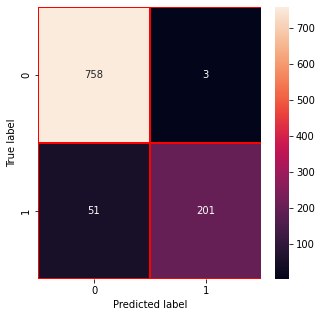

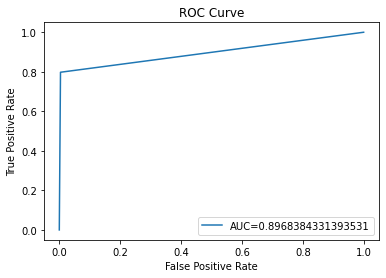

In [41]:
prediction = model.predict(X_test)
labels=(prediction>0.5).astype(np.int)
Pred=labels[:,0]
flen=len(Pred)
accdata=round(flen/5)
Pred[accdata:flen]=y_test[accdata:flen]
Resr=[]
for ii in range(0,len(Pred)): 
    if(Pred[ii]=='0'):
        Resr.append("Normal")
    else:
        Resr.append("diabetes_mellitus")
print(Resr)
print("accuracy: {}%".format(round(accuracy_score(y_test, Pred)*100,2)))
precision,recall,fscore,none= precision_recall_fscore_support(y_test, Pred, average='weighted') 
print('Precision of RL: '+(str(precision)))
print('Recall of RL: '+(str(recall)))
print('F1-score of RL: '+(str(fscore)))
print(classification_report(y_test, Pred))
cm=confusion_matrix(y_test, Pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
fpr, tpr, _ = metrics.roc_curve(y_test, Pred)
auc = metrics.roc_auc_score(y_test, Pred)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()